In [1]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()
%matplotlib inline

/Users/mkt-mac/anaconda3/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Import Data

In [2]:
with zipfile.ZipFile('./data/380000-lyrics-from-metrolyrics.zip') as zip:
    with zip.open('lyrics.csv') as myZip:
        df = pd.read_csv(myZip) 

In [3]:
df.columns

Index(['index', 'song', 'year', 'artist', 'genre', 'lyrics'], dtype='object')

In [4]:
df = df.replace({'\n': ' '}, regex=True)
df.head()

,index,song,year,artist,genre,lyrics
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing? You know I'm gonna cut..."
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy, it's like you seem..."
2,2,honesty,2009,beyonce-knowles,Pop,If you search For tenderness It isn't hard to ...
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I [Verse 1:] If I wrote a..."
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


# Details

In [6]:
print("Data Shape    :", df.shape)
print("Song Count    :", len(df.song.unique()))
print("Year Count    :", len(df.year.unique()))
print("Artist Count  :", len(df.artist.unique()))
print("Genre Count   :", len(df.genre.unique()))

Data Shape    : (362237, 6)
Song Count    : 250473
Year Count    : 52
Artist Count  : 18231
Genre Count   : 12


## Word Count Analysis

In [7]:
# count words of lyrics
df["word_count"] = df.lyrics.str.split().str.len()

In [8]:
df.word_count.describe()

count    266557.000000
mean        227.136504
std         157.577703
min           1.000000
25%         130.000000
50%         192.000000
75%         279.000000
max        8195.000000
Name: word_count, dtype: float64

/Users/mkt-mac/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/mkt-mac/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


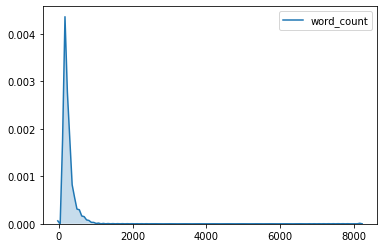

In [9]:
# density plot with shade
sns.kdeplot(df['word_count'], shade=True)
plt.show()

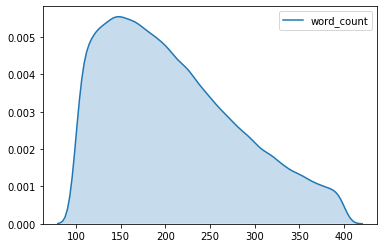

In [10]:
MAX_WORD = 400
MIN_WORD = 100
# exclude >1000
dfClean = df[df.word_count<=MAX_WORD]
# exglude also < 100
dfClean = dfClean[dfClean.word_count>=MIN_WORD]
sns.kdeplot(dfClean['word_count'], shade=True)
plt.show()

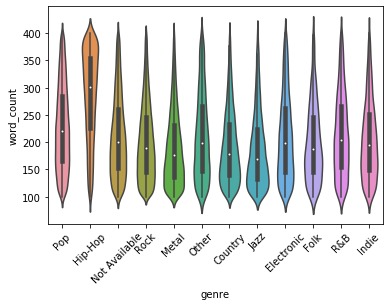

In [11]:
sns.violinplot( y=dfClean["word_count"], x=dfClean["genre"])
plt.xticks(rotation=45)
plt.show()

In [12]:
dfClean.word_count.describe()

count    200735.000000
mean        208.823683
std          73.780281
min         100.000000
25%         149.000000
50%         196.000000
75%         258.000000
max         400.000000
Name: word_count, dtype: float64

# Genre Analysis and Cleaning

## Remove Genres

We remove some genres that are underrepresented.

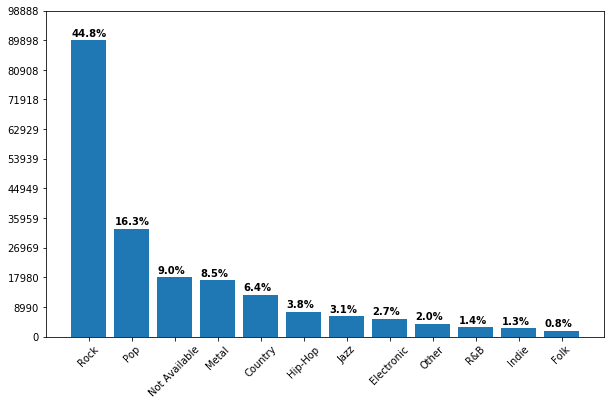

In [13]:
def plot_genres(df):
    ## Barplot for Genre count
    counts = df.genre.value_counts()
    x = counts.keys()
    max_count = df.genre.value_counts().max()
    proportions = counts/counts.sum()

    fig, ax = plt.subplots(figsize=(10,6))
    ax.bar(x, counts)
    for i, v in enumerate(x):
        ax.text(i-0.4, counts[i]+1300, "%.1f%%" % (proportions[i]*100), fontweight='bold')
    plt.xticks(rotation=45)
    plt.yticks(np.arange(0, max_count + max_count/10, max_count/10))
    plt.show()

plot_genres(dfClean)

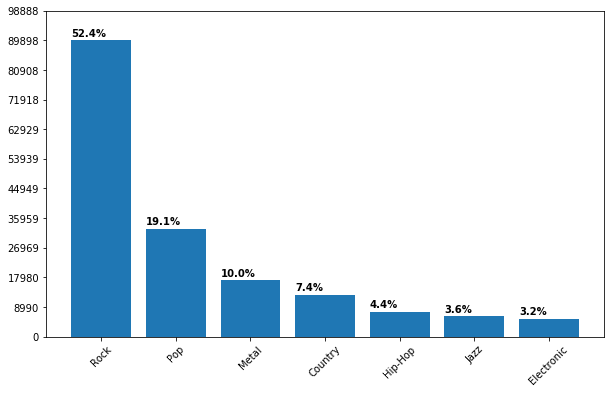

In [14]:
# We dont need Not Available and Other genres!
# We also exclude R&B, Indie and Folk, since they are very underrepresented
removeGenres = ["Not Available",
               "Other",
               "R&B",
               "Indie",
               "Folk"]
dfNew = dfClean.copy()
for g in removeGenres:
    dfNew = dfNew[dfNew.genre!=g]
dfClean = dfNew
del(dfNew)
plot_genres(dfClean)

In [15]:
genre_mapping = {v:k for k, v in enumerate(set(dfClean.genre))}
genre_mapping

{'Jazz': 0,
 'Electronic': 1,
 'Hip-Hop': 2,
 'Country': 3,
 'Metal': 4,
 'Pop': 5,
 'Rock': 6}

In [16]:
dfClean["genre_id"] = dfClean.genre.replace(genre_mapping)

In [17]:
dfClean.head()

,index,song,year,artist,genre,lyrics,word_count,genre_id
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy, it's like you seem...",258.0,5
2,2,honesty,2009,beyonce-knowles,Pop,If you search For tenderness It isn't hard to ...,170.0,5
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po...",312.0,5
5,5,all-i-could-do-was-cry,2009,beyonce-knowles,Pop,I heard Church bells ringing I heard A choir s...,144.0,5
6,6,once-in-a-lifetime,2009,beyonce-knowles,Pop,This is just another day that I would spend Wa...,295.0,5


## Split the data to Train, Val and Test

In [18]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(dfClean[["genre", "lyrics", "genre_id"]], test_size=0.1, random_state=12345)
df_train, df_val = train_test_split(df_train, test_size=0.11, random_state = 12345)

In [19]:
print("Train Data :", df_train.shape, 
      "\nVal Data   :", df_val.shape, 
      "\nTest Data  :", df_test.shape)

Train Data : (137498, 3) 
Val Data   : (16995, 3) 
Test Data  : (17166, 3)


In [20]:
df_train.head()

,genre,lyrics,genre_id
172319,Rock,I used to think the world was flat Rarely thre...,6
72629,Rock,"I wanna be your mason baby, I wanna build a li...",6
264321,Hip-Hop,(Dre Dog talking) Drop it Yeah! (yeah) Wasup? ...,2
284311,Rock,i've got a question for you before i'm put in ...,6
343800,Rock,(wilko johnson) I'll get nervous when we meet ...,6


## Balance the Train Data

The data that we have is very unbalanced as we can see from above. We will sample this data by setting a limit for each genre. 

In [21]:
lyricLimit = min(df_train.groupby("genre").count().lyrics)
print("Lyric Limit per Genre:", lyricLimit)
genres = df_train.genre.unique()
balanced_df_train = pd.DataFrame()
for g in genres:
    balanced_df_train = balanced_df_train.append(df_train[df_train.genre==g].sample(lyricLimit, replace=False, random_state=12345))

Lyric Limit per Genre: 4306


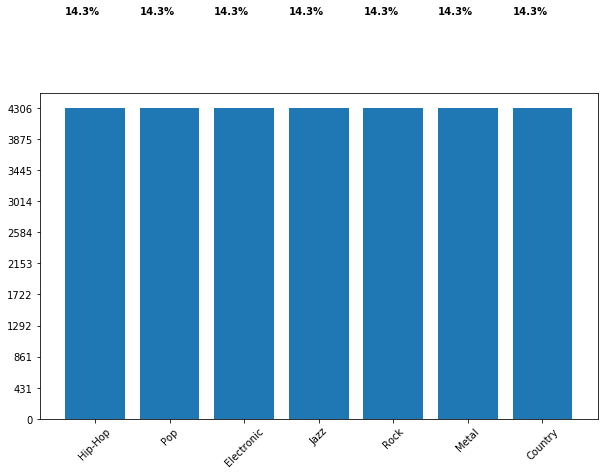

Train Data : (30142, 3)


In [22]:
df_train = balanced_df_train
del(balanced_df_train)
plot_genres(df_train)
print("Train Data :", df_train.shape)

## Save Data Splits

In [25]:
df_train.to_csv("./data/train_unclean.csv.zip", compression="zip")
df_val.to_csv("./data/val_unclean.csv.zip", compression="zip")
df_test.to_csv("./data/test_unclean.csv.zip", compression="zip")